Feel free to change num_threads to suit your computational resources. 

In [1]:
%env NUMBA_WARNINGS 1
%env NUMBA_NUM_THREADS 8

import sys
sys.path.append('../')

import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))
mkl_set_num_threads(8)
print(mkl_get_max_threads())

env: NUMBA_WARNINGS=1
env: NUMBA_NUM_THREADS=8
8
8


In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pickle as pkl
import time

from quffka.experiment import abs_errors
from quffka.dataset import make_dataset, sample_dataset
from quffka.visualize import plot_errors

import matplotlib
matplotlib.rcParams["font.family"] = "Dejavu Sans"

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'

# USPS

In [3]:
approx_types = ['B'] #['G', 'Gort', 'ROM', 'QMC', 'GQ', 'B']
# halton sequence generator cannot generate large enough sequences for datasets CIFAR100 and LEUKEMIA
approx_types_large_d = ['B'] #['G', 'Gort', 'ROM', 'B']
datasets = [
    'Powerplant',
    'LETTER',
    'USPS',
    # 'MNIST',
    'CIFAR100',
    'LEUKEMIA'
]
kernels = ['Arccos 0', 'Arccos 1', 'RBF']

In [ ]:
%%time
# %%telepyth


from quffka.dataset import PARAMS

# save dir
directory = 'results/'
if not os.path.exists(directory):
    os.makedirs(directory)


errs = {}
# set sample_params = None to get default parameters as in the paper, but be aware it takes long time
sample_params = [1, 10, 100, 0, 1, None, None]

epsilon = np.array([1, 1/2, 1/2.5, 1/3, 1/3.5, 1/3.75, 1/4, 1/4.25, 1/4.5, 1/4.75, 1/5])

degrees = np.ceil(1 / epsilon**2 * np.log(1 / epsilon)).astype(int)
degrees = np.maximum(degrees, 1)
print(degrees)
for name in datasets:
    print(name)
    errs[name] = {}
    
    sample_params[-2] = PARAMS[name][-2]
    sample_params[-1] = PARAMS[name][-1]
    sample_params[2] = min(sample_params[2], PARAMS[name][2])
    print(sample_params)
    
    dataset, params = make_dataset(name)#, sample_params)
    start_deg, max_deg, runs, shift, step, nsamples, _ = sample_params
    
    X = sample_dataset(nsamples, dataset)
    Y = sample_dataset(nsamples, dataset)
    
    if X.shape[1] > 784:
        approx_types = approx_types_large_d
        
    for kernel in kernels:
        errs[name][kernel] = abs_errors(dataset, kernel, approx_types, degrees, runs,
                                        nsamples=sample_params[-2])
        
    with open(f"{directory}{name}_{kernel}_{sample_params!r}", 'wb') as f:
        pkl.dump(errs, f)

  0%|          | 0/100 [00:00<?, ?it/s]

[ 1  3  6 10 16 19 23 27 31 36 41]
Powerplant
[1, 10, 100, 0, 1, 550, 8500]


  1%|          | 1/100 [00:00<00:14,  6.84it/s]

LETTER
[1, 10, 100, 0, 1, 550, 10000]


  0%|          | 0/100 [00:00<?, ?it/s]

USPS
[1, 10, 100, 0, 1, 550, 4500]


100%|██████████| 100/100 [15:01<00:00,  9.01s/it]


CIFAR100
[1, 10, 50, 0, 1, 550, 50000]


  0%|          | 0/10 [00:00<?, ?it/s]

LEUKEMIA
[1, 10, 10, 0, 1, 10, 38]


 50%|█████     | 5/10 [03:06<03:06, 37.22s/it]

In [6]:
errs['Powerplant']['Arccos 0']['B'].mean(axis=1)

array([0.67760193, 0.47010944, 0.34724026, 0.29397532, 0.23356763,
       0.21923733, 0.20638423, 0.18856614, 0.17887212, 0.17189666,
       0.15511282])

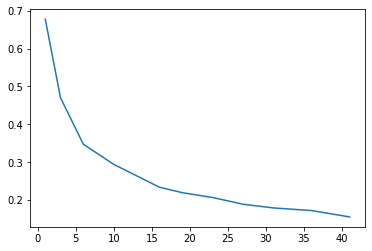

In [7]:
plt.plot(degrees, errs['Powerplant']['Arccos 0']['B'].mean(axis=1))

In [9]:
n_data, n_kernels

(5, 3)

In [74]:
errs[dataset_name][kernel]['B'].std(axis=1)

array([2.94746505e-05, 1.20412789e-05, 6.85212049e-06, 7.51674414e-06,
       7.10981568e-06, 3.56773610e-06, 5.73979759e-06, 4.24771135e-06,
       5.57431705e-06, 6.24400576e-06, 3.44838581e-06])

In [77]:
errs[dataset_name][kernel]['B'].mean(axis=1)

array([5.42767200e-05, 2.41483967e-05, 1.55688124e-05, 1.36151494e-05,
       1.10086123e-05, 8.84777062e-06, 9.29278774e-06, 8.91222898e-06,
       9.94862520e-06, 9.02100524e-06, 6.98501408e-06])

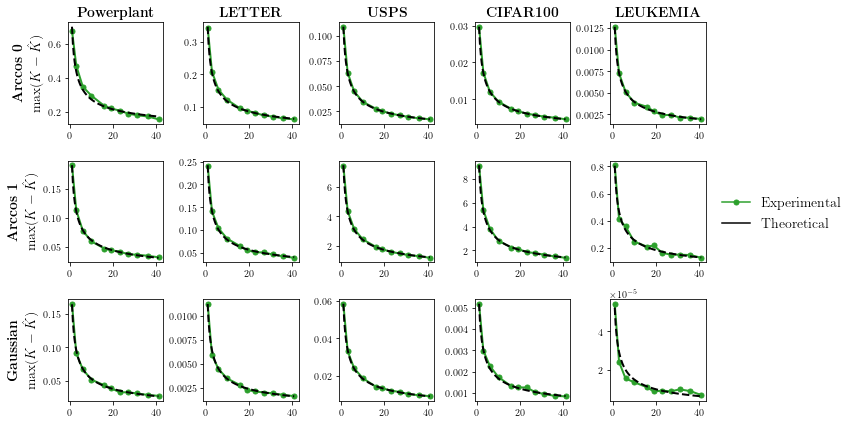

In [80]:
from sklearn.linear_model import Ridge, Lasso, HuberRegressor

from matplotlib.ticker import LogFormatterMathtext, MaxNLocator, \
                              ScalarFormatter
from matplotlib.lines import Line2D

def feat(x):
    return np.sqrt(1 / x)


n_data = len(datasets)
n_kernels = len(kernels)

color = 'C2'

fig, axes = plt.subplots(n_kernels, n_data, figsize=(n_data * 2, n_kernels * 2))
for i, dataset_name in enumerate(datasets):
    for j, kernel in enumerate(kernels):

        y = errs[dataset_name][kernel]['B'].mean(axis=1)

        model = HuberRegressor()
        model.fit(feat(degrees).reshape(-1, 1), y)

        x = np.linspace(1, degrees.max(), 100)
        y_hat = model.predict(feat(x).reshape(-1, 1))

        std = errs[dataset_name][kernel]['B'].mean(axis=1)
        mean = errs[dataset_name][kernel]['B'].mean(axis=1)
        
        #axes[j, i].fill_between(degrees, mean - std, mean + std, color=color, alpha=0.3)
        
        axes[j, i].plot(degrees, mean,
                        '.-', c=color, lw=2, markersize=10)
        axes[j, i].plot(x, y_hat, '--k', lw=2)
        
        if j == 0:
            axes[j, i].set_title(r'\textbf{%s}' % dataset_name, fontsize=14)
        
        if i == 0:
            kernel = 'Gaussian' if kernel == 'RBF' else kernel
            axes[j, i].set_ylabel(r'\textbf{%s}' % kernel + '\n' + r'$\max(K - \hat{K}$)',
                                  fontsize=14)
        
patches = []
patches.append(Line2D([], [], color=color,
               marker='.', markersize=10,
               label='Experimental'))
patches.append(Line2D([], [], color='k',
               markersize=10,
               label='Theoretical'))
        
fig.legend(bbox_to_anchor=(1, 0.55),
           loc=2, borderaxespad=0., framealpha=0.0,
           fontsize=14, handles=patches)
fig.tight_layout()
fig.savefig('../theoretical_results.pdf', bbox_inches="tight")

In [70]:
n_data, n_kernels

(1, 3)

# Plot kernel approximation accuracy

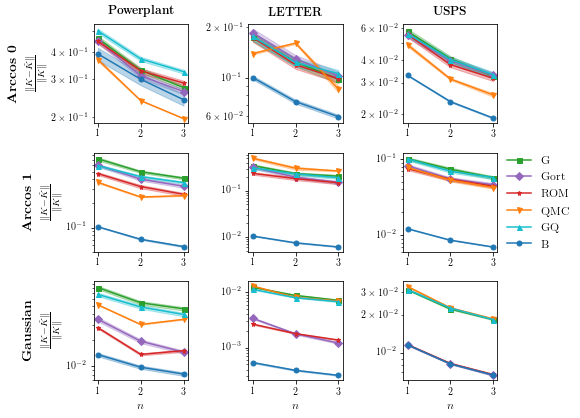

200

In [10]:
fig = plot_errors(errs, datasets, kernels, approx_types, 
                  semilogy=True, acc=False, exact=None, 
                  params=sample_params)
# tp.send_figure(fig, 'Kernel approximation results.')